In [1]:
!pip install --quiet gdown

In [2]:
import gdown
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
fear_greed_path = '/content/drive/MyDrive/ds_Chitragupt_Maurya/csv_files/fear_greed_index.csv'
trade_data_path = '/content/drive/MyDrive/ds_Chitragupt_Maurya/csv_files/historical_data.csv'

In [4]:
fg_df = pd.read_csv(fear_greed_path)
print(f'Fear and Greed data set: \n {fg_df.head(5)}.\n.\n.\n.\n{fg_df.tail(5)}')


Fear and Greed data set: 
     timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05.
.
.
.
       timestamp  value classification        date
2639  1745818200     54        Neutral  2025-04-28
2640  1745904600     60          Greed  2025-04-29
2641  1745991000     56          Greed  2025-04-30
2642  1746077400     53        Neutral  2025-05-01
2643  1746163800     67          Greed  2025-05-02


In [5]:
trade_df = pd.read_csv(trade_data_path)
print(f'Historical data set: \n {trade_df.head(5)}.\n.\n.\n.\n{trade_df.tail(5)}')

Historical data set: 
                                       Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \


In [6]:
print(fg_df.shape)
print(fg_df.columns)
print(len(fg_df.columns))

(2644, 4)
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')
4


In [7]:
print(trade_df.shape)
print(trade_df.columns)
print(len(trade_df.columns))

(211224, 16)
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')
16


In [8]:
fg_df["date"] = pd.to_datetime(fg_df['date'], errors='coerce')
fg_df['date_only'] = fg_df['date'].dt.date

In [9]:
print(fg_df.columns)
print(len(fg_df.columns))

Index(['timestamp', 'value', 'classification', 'date', 'date_only'], dtype='object')
5


In [10]:
trade_df['Timestamp IST'] = pd.to_datetime(trade_df['Timestamp IST'], errors='coerce')
trade_df['trade_date'] = trade_df['Timestamp IST'].dt.date

In [11]:
print(trade_df.columns)
print(len(trade_df.columns))

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'trade_date'],
      dtype='object')
17


Merge operation is crashing, kernel due to memory over load.

Therefore using filtered dataframes and "gc" for the garbage collector.

In [12]:
import gc

In [13]:
filtered_trade_df = trade_df[['Timestamp IST', 'Closed PnL', 'Direction', 'trade_date']].copy()
filtered_trade_df = filtered_trade_df[filtered_trade_df['trade_date'] >= pd.to_datetime('2024-07-01').date()]

In [14]:
filtered_fg_df = fg_df[['date_only', 'classification']].copy()


In [15]:
merged_df = pd.merge(
    filtered_trade_df,
    filtered_fg_df,
    left_on='trade_date',
    right_on='date_only',
    how='left'
)

In [16]:
gc.collect()

0

In [17]:
print("Merged Data Preview:")
print(merged_df[['trade_date', 'classification']].head())

Merged Data Preview:
   trade_date classification
0  2025-04-03           Fear
1  2025-04-03           Fear
2  2025-04-03           Fear
3  2025-04-03           Fear
4  2025-04-03           Fear


In [18]:
merged_df_clean = merged_df.dropna(subset=['Closed PnL','classification'])
average_pnl = merged_df_clean.groupby('classification')['Closed PnL'].mean()

In [19]:
print(f"Average PnL by Sentiment: \n {average_pnl}")

Average PnL by Sentiment: 
 classification
Extreme Fear       1.891632
Extreme Greed    242.622190
Fear             128.987896
Greed             72.194501
Neutral           21.687314
Name: Closed PnL, dtype: float64


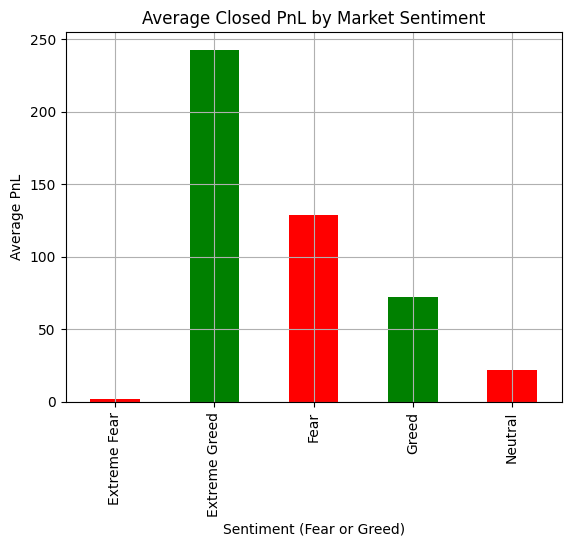

In [20]:
average_pnl.plot(kind='bar', color=['red', 'green'])
plt.title("Average Closed PnL by Market Sentiment")
plt.ylabel("Average PnL")
plt.xlabel("Sentiment (Fear or Greed)")
plt.grid(True)
plt.show()
plt.close()

In [21]:
trade_counts = merged_df['classification'].value_counts()
print("Number of Trades by Sentiment:")
print(trade_counts)

Number of Trades by Sentiment:
classification
Fear             13794
Greed             7038
Extreme Greed     3877
Neutral           2491
Extreme Fear      2326
Name: count, dtype: int64


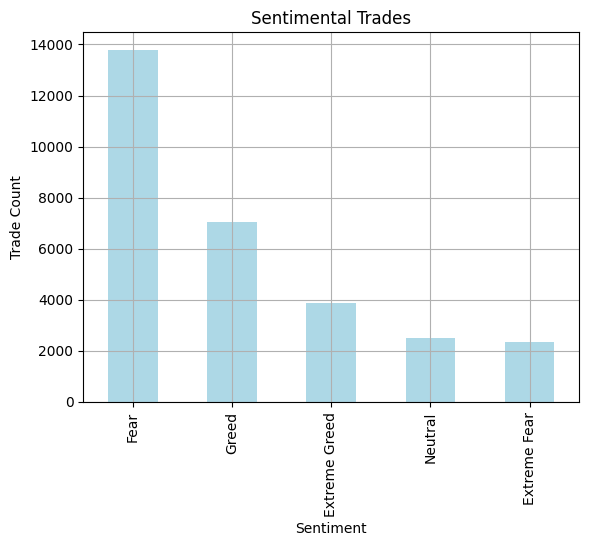

In [22]:
plt.close()

trade_counts.plot(kind='bar', color='lightblue')
plt.title("Sentimental Trades")
plt.ylabel("Trade Count")
plt.xlabel("Sentiment")
plt.grid(True)
plt.show()


In [23]:
direction_sentiment = merged_df_clean.groupby(['classification', 'Direction']).size().unstack()
print("Trade Direction by Sentiment:")
print(direction_sentiment)

Trade Direction by Sentiment:
Direction          Buy  Close Long  Close Short  Long > Short  Open Long  \
classification                                                             
Extreme Fear      77.0       673.0        106.0           NaN      984.0   
Extreme Greed    314.0       274.0        350.0           1.0      202.0   
Fear            1003.0      2669.0       2743.0           5.0     3521.0   
Greed           1161.0      1764.0       1130.0           3.0     1144.0   
Neutral          377.0       313.0        331.0           NaN      214.0   

Direction       Open Short    Sell  Short > Long  Spot Dust Conversion  
classification                                                          
Extreme Fear         441.0    43.0           1.0                   1.0  
Extreme Greed        770.0  1962.0           1.0                   3.0  
Fear                3061.0   771.0           4.0                  17.0  
Greed               1057.0   774.0           3.0                   2.0  

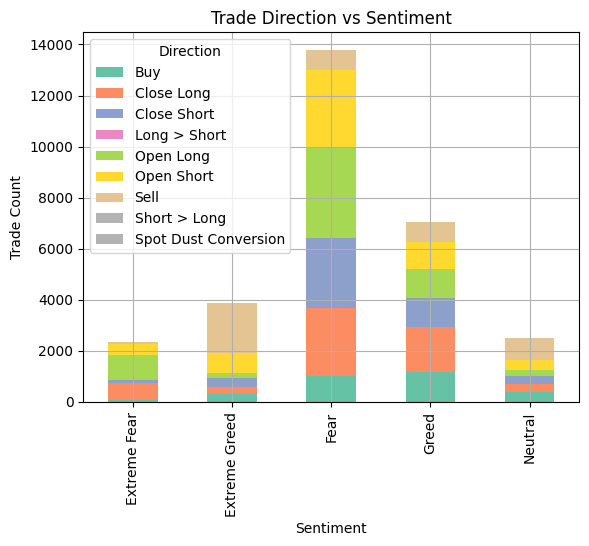

In [24]:
plt.close()

direction_sentiment.plot(kind='bar', stacked=True, colormap='Set2')
plt.title("Trade Direction vs Sentiment")
plt.ylabel("Trade Count")
plt.xlabel("Sentiment")
plt.grid(True)
plt.legend(title="Direction")
plt.show()


/tmp/ipython-input-25-1052601928.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df_clean, x='classification', y='Closed PnL', palette='coolwarm')


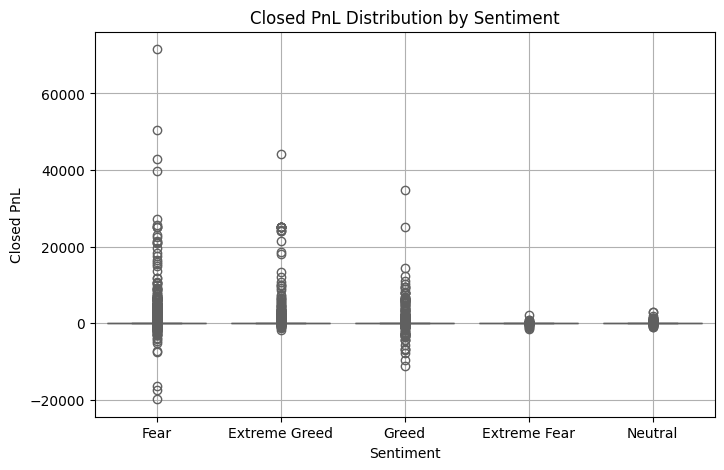

In [25]:
plt.close()

plt.figure(figsize=(8, 5))
sns.boxplot(data=merged_df_clean, x='classification', y='Closed PnL', palette='coolwarm')
plt.title("Closed PnL Distribution by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Closed PnL")
plt.grid(True)
plt.show()
